In [1]:
import import_ipynb
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import numpy as np
import pytorch_lightning as pl
import torch.nn.functional as F
from torch.optim import Adam, SGD
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import TensorBoardLogger
import numpy as np
import torchvision

from sampler import *
from data_modules import *
from callbacks import *

In [2]:
class Generator(nn.Module):
    def __init__(self, input_size, output_size, network_width, network_depth):
        super().__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.network_depth = network_depth
        self.l1 = nn.Linear(self.input_size, network_width)
        self.l2 = nn.Linear(network_width, network_width)
        self.l3 = nn.Linear(network_width, self.output_size)
        self.bn = nn.BatchNorm1d(network_width)
        
    def forward(self, x):
        #x = x.flatten(start_dim=1)
        x = self.l1(x)
        x = self.bn(F.leaky_relu(x))
        for _ in range(self.network_depth - 2):
            x = self.l2(x)
            x = self.bn(F.leaky_relu(x))
        x =  F.softmax(self.l3(x))
        return x.view(-1, self.output_size)

class Discriminator(nn.Module):
    def __init__(self, input_size, network_width, network_depth):
        super().__init__()
        self.network_depth = network_depth
        self.input_size = input_size
        self.l11 = nn.Linear(self.input_size, network_width)
        self.l2 = nn.Linear(network_width, network_width)
        self.l3 = nn.Linear(network_width, 1)
        self.sigmoid = nn.Sigmoid()
        self.bn = nn.BatchNorm1d(network_width)

    def forward(self, x):
        #x = x.flatten(start_dim=1)
        x = self.l11(x)
        x = self.bn(F.leaky_relu(x))
        for _ in range(self.network_depth - 2):
            x = self.l2(x)
            #x = self.bn(F.leaky_relu(x))
        x = self.sigmoid(self.l3(x))
        return x

In [3]:
class Generator(nn.Module):
    def __init__(self, input_size, output_size, network_width, network_depth):
        super().__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.network_depth = network_depth
        self.l1 = nn.Linear(self.input_size, network_width)
        self.l2 = nn.Linear(network_width, network_width)
        self.l3 = nn.Linear(network_width, self.output_size)
        self.bn = nn.BatchNorm1d(network_width)
        
    def forward(self, x):
        #x = x.flatten(start_dim=1)
        x = self.l1(x)
        x = self.bn(F.leaky_relu(x))
        for _ in range(self.network_depth - 2):
            x = self.l2(x)
            x = self.bn(F.leaky_relu(x))
        x =  self.l3(x)
        x = torch.cat((F.tanh(x[:,0]), F.sigmoid(x[:,1])), dim=-1)
        return x.view(-1, self.output_size)

In [4]:
class GAN(pl.LightningModule):
    def __init__(self, dataset, image_size=28, batch_size=64, latent_dim = 3, generator_width=800, generator_depth=6,
                discriminator_width=400, discriminator_depth=3, discriminator_training_loops=1, num_workers=16):
        super().__init__()
        self.image_size = image_size
        self.batch_size = batch_size
        self.generator_width = generator_width
        self.generator_depth = generator_depth
        self.discriminator_width = discriminator_width
        self.discriminator_depth = discriminator_depth
        self.discriminator_training_loops = discriminator_training_loops
        self.latent_dim = latent_dim
        self.generator = Generator(self.latent_dim, 2, 30, 3)#self.image_size, self.generator_width, self.generator_depth)
        self.discriminator = Discriminator(2, 25, 2)#self.image_size, self.discriminator_width, self.discriminator_depth)
        self.automatic_optimization=False
        self.dataset = dataset
        self.num_workers = num_workers
        
    def train_dataloader(self):
        return DataLoader(self.dataset,
                          self.batch_size * self.discriminator_training_loops,
                          shuffle=True,
                          num_workers=self.num_workers)
    
    def training_step(self, batch, batch_idx):
        X, _ = batch
        generator_optimizer, discriminator_optimizer = self.optimizers()
        for data_batch in torch.split(X, self.batch_size):
            noise_batch = torch.randn(self.batch_size, self.latent_dim).cuda()
            discriminator_optimizer.zero_grad()
            loss_discriminator = self.discriminator_loss(data_batch, noise_batch)
            self.manual_backward(loss_discriminator)
            
            grad_max = max([torch.max(p.grad) for p in self.discriminator.parameters() if p.grad is not None])            
            
            discriminator_optimizer.step()
        generator_optimizer.zero_grad()
        noise_batch = torch.randn(self.batch_size, self.latent_dim).cuda()
        loss_generator = self.generator_loss(noise_batch)
        self.manual_backward(loss_generator)

        grad_max2 = max([torch.max(p.grad) for p in self.generator.parameters() if p.grad is not None])
            
        generator_optimizer.step()
        self.logger.experiment.add_scalar("Generator_loss", loss_generator, self.current_epoch)
        self.logger.experiment.add_scalar("Discriminator_loss", loss_discriminator, self.current_epoch)
        self.logger.experiment.add_scalar("Grad_max_before", grad_max, self.current_epoch)
        self.logger.experiment.add_scalar("Grad_max_before2", grad_max2, self.current_epoch)
        return 
    
    def configure_optimizers(self):
        generator_optimizer = Adam(self.generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
        discriminator_optimizer = SGD(self.discriminator.parameters(), lr=0.0002)
        return generator_optimizer, discriminator_optimizer
    
    def generator_loss(self, noise):
        return -torch.mean(torch.log(self.discriminator(self.generator(noise)) + 1e-16))
    
    def discriminator_loss(self, data, noise):
        return -0.5 * torch.mean(torch.log(self.discriminator(data) + 1e-16)) - \
    0.5 * torch.mean(torch.log(1-self.discriminator(self.generator(noise)) + 1e-16))
    
    def on_train_epoch_end(self):
        if self.current_epoch % 20 == 0:
            for i in range(5):
                generated_points = self.generator(torch.randn(self.batch_size, self.latent_dim).cuda()).cpu()
                image = make_img(generated_points[:,0], generated_points[:,1])
                image[0,torch.LongTensor([i for i in range(9)]), torch.LongTensor([i*i for i in range(9)])]=1
                self.logger.experiment.add_image("image_epoch"+str(self.current_epoch),
                                                 image,
                                                self.current_epoch,
                                                dataformats='CHW')

In [5]:
def make_img(x,y):
    canvas = np.ones((1000,1000))
    def plot_point(canvas, coordinates):
        l = int(canvas.shape[0]/100)
        canvas[coordinates[0]-l:coordinates[0]+l, coordinates[1]-l:coordinates[1]+l] = 0
    def transf(m):
        return ((m + 1)*500).to(torch.int).numpy()
    def transfy(m):
        return (m *1000).to(torch.int).numpy()
    for m,n in zip(transf(x), transf(y)):
        plot_point(canvas, [n,m])
    return torchvision.utils.make_grid(torch.Tensor(canvas))

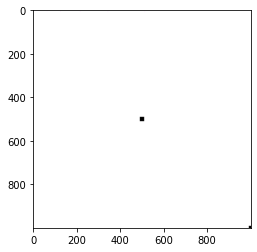

In [6]:
l = make_img(torch.Tensor([i**2 for i in range(99)]), torch.Tensor([i for i in range(99)])).numpy()
l[1,torch.LongTensor([i for i in range(9)]), torch.LongTensor([i*i*i for i in range(9)])]=0

plt.imshow( np.transpose(l, (1, 2, 0)))

In [7]:
l[1]

array([[0., 1., 1., ..., 1., 1., 1.],
       [1., 0., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.]], dtype=float32)

In [8]:
class MyDataset(Dataset):
    def __init__(self, data):
        self.data = data
        
    def __getitem__(self, idx):
        x = torch.FloatTensor(self.data[idx])
        return x, 0
    
    def __len__(self):
        return len(self.data)

# GAN for 2D shapes

In [9]:
unif = np.random.uniform(0, 1, (8000, 8000))
x = unif[0] * np.cos(unif[1])
y = unif[0] * np.sin(unif[1])

In [10]:
x = unif[0]
y = x**3

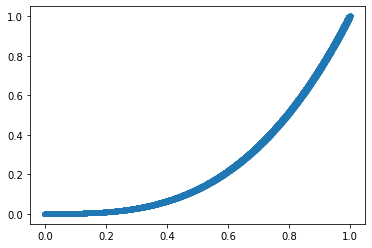

In [11]:
plt.plot(x,y, 'p')

In [12]:
ds = MyDataset(np.transpose(np.vstack((x,y))))

In [13]:
%reload_ext tensorboard
%tensorboard --logdir my_logs/

In [14]:
logger = TensorBoardLogger('my_logs', 'GAN')
tr1 = Trainer(max_epochs=500, gpus=1, logger=logger)
model = GAN(ds)

MisconfigurationException: You requested GPUs: [0]
 But your machine only has: []

In [49]:
tr1.fit(model)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type          | Params
------------------------------------------------
0 | generator     | Generator     | 1.2 K 
1 | discriminator | Discriminator | 801   
------------------------------------------------
2.0 K     Trainable params
0         Non-trainable params
2.0 K     Total params
0.008     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

/home/johnny/.virtualenvs/jup/lib/python3.8/site-packages/torch/nn/functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/johnny/.virtualenvs/jup/lib/python3.8/site-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [50]:
generator = Generator(3,2,25,3)
generator.eval()
generator.to('cpu')

points = generator(torch.randn(100,3))

In [51]:
points

tensor([[-2.3411e-03, -1.8702e-01],
        [-4.1350e-02, -1.1291e-01],
        [-1.4948e-02,  4.0677e-02],
        [-1.6868e-02,  1.6395e-02],
        [-2.1017e-02, -4.2681e-02],
        [ 2.0820e-02, -5.6173e-03],
        [ 1.0263e-02, -4.7417e-02],
        [ 1.1006e-02, -5.0794e-02],
        [ 3.2941e-02, -4.3030e-03],
        [-1.0690e-02,  7.7811e-03],
        [ 2.2699e-02, -1.5344e-02],
        [-3.5862e-02,  1.7627e-02],
        [ 1.8101e-02, -4.2083e-02],
        [-7.3619e-02, -5.1184e-02],
        [-1.2799e-01,  3.4587e-02],
        [-4.8734e-03, -5.9408e-04],
        [-2.5491e-02,  3.9461e-02],
        [-2.9826e-03, -2.2362e-02],
        [-4.5484e-02, -3.7756e-02],
        [ 6.6784e-02, -1.8187e-01],
        [ 3.0647e-04,  1.2095e-04],
        [-2.4446e-02, -2.7782e-02],
        [-7.1686e-02, -1.1068e-02],
        [-2.8820e-02, -5.3256e-03],
        [-3.5530e-02, -1.0696e-02],
        [-8.2439e-03,  4.0599e-02],
        [-8.0787e-02,  3.3579e-02],
        [ 7.2898e-03,  3.136

In [52]:
p = points.detach().numpy()

In [ ]:
d = DataLoader(ds, batch_size=100)

In [ ]:
k = next(iter(d))

In [ ]:
m = k[0].detach().numpy()

/home/johnny/.virtualenvs/jup/lib/python3.8/site-packages/torch/nn/functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/home/johnny/.virtualenvs/jup/lib/python3.8/site-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


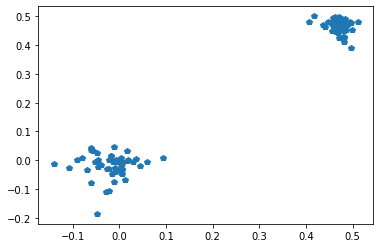

In [74]:
points = generator(torch.randn(100,3))
p = points.cpu().detach().numpy()
plt.plot(p[:, 0], p[:, 1], 'p')
#plt.plot(m[:,0],m[:, 1],'p',c='r')

In [ ]:
model.discriminator.eval()

In [ ]:
model.discriminator(torch.FloatTensor([[100,1]]))

In [ ]:
torch.FloatTensor([x,y]).view(1,-1,2)

In [ ]:
plt.hist(np.squeeze(model.discriminator(torch.FloatTensor(np.vstack((x,y)).transpose())).detach().numpy()))

In [ ]:
model.discriminator(torch.FloatTensor(np.vstack((x,y)).transpose()).unsqueeze(-1))

In [ ]:
model.discriminator(torch.FloatTensor([x,y]))

In [ ]:
model.discriminator(torch.FloatTensor(points))

In [ ]:
plt.plot(points[:,0], points[:,1], 'p')
plt.plot(x,y,'p',c='r')

# GAN for non local distributions

In [ ]:
n = 100000
local = sample_no_signalling(n, True, output_format=0)
non_local =  sample_no_signalling(n, False, output_format=0)
ds = MyDataset(non_local)

In [ ]:
logger = TensorBoardLogger('my_logs', 'GAN')
tr1 = Trainer(max_epochs=500, gpus=1, logger=logger)

In [ ]:
%reload_ext tensorboard
%tensorboard --logdir my_logs/

In [ ]:
model = GAN(ds)
tr1.fit(model)